In [1]:
import os
import glob
import numpy as np
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns

In [2]:
def get_3D_Dose_dif(pred, gt, possible_dose_mask=None):
    if possible_dose_mask is not None:
        pred = pred[possible_dose_mask > 0]
        gt = gt[possible_dose_mask > 0]

    dif = np.mean(np.abs(pred - gt))
    return dif


def get_DVH_metrics(_dose, _mask, mode, spacing=None):
    output = {}

    if mode == "target":
        _roi_dose = _dose[_mask > 0]
        # D1
        output["D1"] = np.percentile(_roi_dose, 99)
        # D95
        output["D95"] = np.percentile(_roi_dose, 5)
        # D99
        output["D99"] = np.percentile(_roi_dose, 1)

    elif mode == "OAR":
        if spacing is None:
            raise Exception("calculate OAR metrics need spacing")

        _roi_dose = _dose[_mask > 0]
        _roi_size = len(_roi_dose)
        _voxel_size = np.prod(spacing)
        voxels_in_tenth_of_cc = np.maximum(1, np.round(100 / _voxel_size))
        # D_0.1_cc
        fractional_volume_to_evaluate = 100 - voxels_in_tenth_of_cc / _roi_size * 100
        if fractional_volume_to_evaluate <= 0:
            output["D_0.1_cc"] = 0.0
        else:
            output["D_0.1_cc"] = np.percentile(_roi_dose, fractional_volume_to_evaluate)
        # Dmean
        output["mean"] = np.mean(_roi_dose)
    else:
        raise Exception("Unknown mode!")

    return output

In [3]:
root_path = "/Users/amithkamath/repo/deepdosesens/"

data_path = os.path.join(root_path, "data", "processed-dldp")
pred_path = os.path.join(root_path, "data", "output-dldp", "output-dldp-6", "Prediction")

results_path = os.path.join(root_path, "results")

dose_scores = pd.read_csv(os.path.join(results_path, "2_dose_score_by_ROI.csv"))
dose_scores = dose_scores.transpose()

dvh_scores = pd.read_csv(os.path.join(results_path, "2_dvh_score_by_ROI.csv"))
dvh_scores = dvh_scores.transpose()

In [4]:
header = dose_scores.iloc[0].to_list()
header = [x[:-8] for x in header]
dose_scores = dose_scores[1:] #take the data less the header row
dose_scores.columns = header #set the header row as the df header

In [7]:
header = dvh_scores.iloc[0].to_list()
header = [x[:-8] for x in header]
dvh_scores = dvh_scores[1:] #take the data less the header row
dvh_scores.columns = header #set the header row as the df header

In [9]:
# select all cases in the folder
cases = sorted(glob.glob(os.path.join(pred_path,"*")))

# define a list to store the dataframes for the dose metrics
dose_score_data = {}
case_names = []

for case in cases:
    # select the case number
    case_nr = case.split("/")[-1]
    case_names.append(case_nr)
    
    # select and read the ground truth dose
    dose_gt_path = glob.glob(os.path.join(data_path, case_nr) + "/Dose.nii.gz")
    dose_gt = sitk.ReadImage(dose_gt_path[0])
    dose_gt = sitk.GetArrayFromImage(dose_gt)

    # select and read the predicted dose
    dose_pred_path = glob.glob(os.path.join(pred_path, case_nr) + "/Dose.nii.gz")
    dose_pred = sitk.ReadImage(dose_pred_path[0])
    dose_pred = sitk.GetArrayFromImage(dose_pred)

    # select all the structures in the folder
    structures = glob.glob(os.path.join(data_path, case_nr) + "/[!Dose]*")

    # define a list to store the dose metrics for the targets and oars
    dose_percent = {}
    names = []

    # For every structure calculate the DVHs and dose metrics
    for structure in structures:
        # select the name of the structure
        name = structure.split("/")[-1].split(".")[0]

        # If CT, ignore
        if name == "CT":
            continue
        
        # turn structure into a boolean mask
        struct = sitk.ReadImage(structure)
        mask = sitk.GetArrayFromImage(struct)
        mask = np.array(mask, dtype='bool')

        diff = get_3D_Dose_dif(dose_pred, dose_gt, possible_dose_mask=mask)
        mean_gt = np.mean(dose_gt[mask > 0])

        # then compute the percentage of difference to the mean GT, and store in dict.
        dose_percent[name] = diff *100 / mean_gt
        names.append(name)

    #subject_data = pd.DataFrame.from_dict(dose_percent, orient='index',
    #                   columns=names)
    dose_score_data[case_nr] = dose_percent

subject_data = pd.DataFrame.from_dict(dose_score_data)
subject_data.to_csv(os.path.join(root_path, "results", "2_test_percentage_errors_median.csv"))

/var/folders/yr/q_0gpqgs1lq_rtbttpk3n9bh0000gn/T/ipykernel_28469/3903893864.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(header, rotation = 45, ha="right")


Text(5.069444444444445, 0.5, '% Difference in Dose for OARs (using median)')

<Figure size 640x480 with 0 Axes>

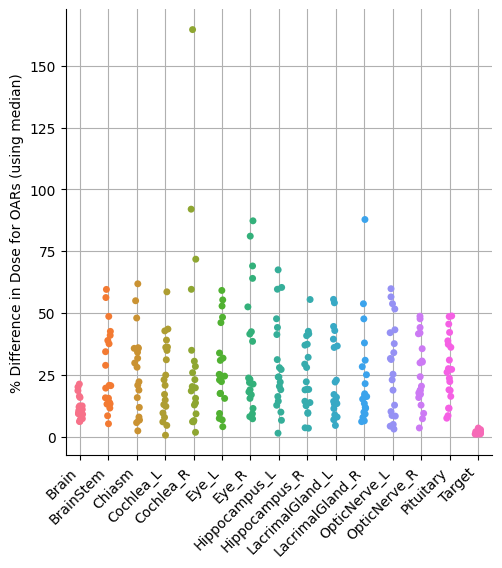

In [10]:
dose_scores = pd.read_csv(os.path.join(results_path, "2_test_percentage_errors_median.csv"))
dose_scores = dose_scores.transpose()
header = dose_scores.iloc[0].to_list()
dose_scores = dose_scores[1:] #take the data less the header row
dose_scores.columns = header #set the header row as the df header
dose_scores = dose_scores.sort_index(axis=1)
header = dose_scores.columns

plt.figure()
sns.catplot(data=dose_scores)
plt.grid()
ax = plt.gca()
ax.set_xticklabels(header, rotation = 45, ha="right")
plt.ylabel("% Difference in Dose for OARs (using median)")
#plt.title("Dose Score for 20 test subjects")

/var/folders/yr/q_0gpqgs1lq_rtbttpk3n9bh0000gn/T/ipykernel_28469/2818392028.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(header, rotation = 45, ha="right")


Text(5.069444444444445, 0.5, '% Difference in Dose for OARs (using mean)')

<Figure size 640x480 with 0 Axes>

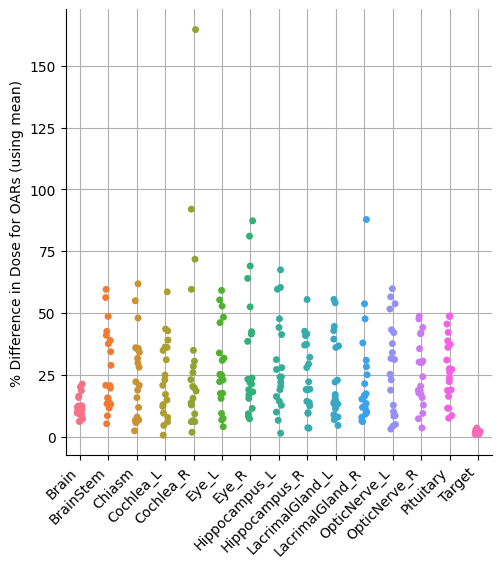

In [11]:
dose_scores = pd.read_csv(os.path.join(results_path, "2_test_percentage_errors.csv"))
dose_scores = dose_scores.transpose()
header = dose_scores.iloc[0].to_list()
dose_scores = dose_scores[1:] #take the data less the header row
dose_scores.columns = header #set the header row as the df header
dose_scores = dose_scores.sort_index(axis=1)
header = dose_scores.columns

plt.figure()
sns.catplot(data=dose_scores)
plt.grid()
ax = plt.gca()
ax.set_xticklabels(header, rotation = 45, ha="right")
plt.ylabel("% Difference in Dose for OARs (using mean)")
#plt.title("Dose Score for 20 test subjects")

In [12]:
# select all cases in the folder
cases = sorted(glob.glob(os.path.join(pred_path,"*")))

# define a list to store the dataframes for the dose metrics
dose_diff_data = {}
dose_mean_data = {}
pred_mean_data = {}
case_names = []

for case in cases:
    # select the case number
    case_nr = case.split("/")[-1]
    case_names.append(case_nr)
    
    # select and read the ground truth dose
    dose_gt_path = glob.glob(os.path.join(data_path, case_nr) + "/Dose.nii.gz")
    dose_gt = sitk.ReadImage(dose_gt_path[0])
    dose_gt = sitk.GetArrayFromImage(dose_gt)

    # select and read the predicted dose
    dose_pred_path = glob.glob(os.path.join(pred_path, case_nr) + "/Dose.nii.gz")
    dose_pred = sitk.ReadImage(dose_pred_path[0])
    dose_pred = sitk.GetArrayFromImage(dose_pred)

    # select all the structures in the folder
    structures = glob.glob(os.path.join(data_path, case_nr) + "/[!Dose]*")

    # define a list to store the dose metrics for the targets and oars
    dose_diff = {}
    dose_mean = {}
    pred_mean = {}
    names = []

    # For every structure calculate the DVHs and dose metrics
    for structure in structures:
        # select the name of the structure
        name = structure.split("/")[-1].split(".")[0]

        # If CT, ignore
        if name == "CT":
            continue
        
        # turn structure into a boolean mask
        struct = sitk.ReadImage(structure)
        mask = sitk.GetArrayFromImage(struct)
        mask = np.array(mask, dtype='bool')

        diff = get_3D_Dose_dif(dose_pred, dose_gt, possible_dose_mask=mask)
        mean_gt = np.max(dose_gt[mask > 0])
        mean_pred = np.max(dose_pred[mask > 0])

        # then compute the percentage of difference to the mean GT, and store in dict.
        dose_diff[name] = diff
        dose_mean[name] = mean_gt
        pred_mean[name] = mean_pred
        names.append(name)

    #subject_data = pd.DataFrame.from_dict(dose_percent, orient='index',
    #                   columns=names)
    dose_diff_data[case_nr] = dose_diff
    dose_mean_data[case_nr] = dose_mean
    pred_mean_data[case_nr] = pred_mean

subject_data = pd.DataFrame.from_dict(dose_diff_data)
subject_data.to_csv(os.path.join(results_path, "2_test_max_difference.csv"))

subject_data = pd.DataFrame.from_dict(dose_mean_data)
subject_data.to_csv(os.path.join(results_path, "2_test_max_gt_dose.csv"))

subject_data = pd.DataFrame.from_dict(pred_mean_data)
subject_data.to_csv(os.path.join(results_path, "2_test_max_pred_dose.csv"))

In [13]:
mean_dose_diff = pd.read_csv(os.path.join(results_path, "2_test_max_difference.csv"))
mean_dose_diff = mean_dose_diff.set_index("Unnamed: 0")
mean_gt_dose = pd.read_csv(os.path.join(results_path, "2_test_max_gt_dose.csv"))
mean_gt_dose = mean_gt_dose.set_index("Unnamed: 0")
mean_pred_dose = pd.read_csv(os.path.join(results_path, "2_test_max_pred_dose.csv"))
mean_pred_dose = mean_pred_dose.set_index("Unnamed: 0")

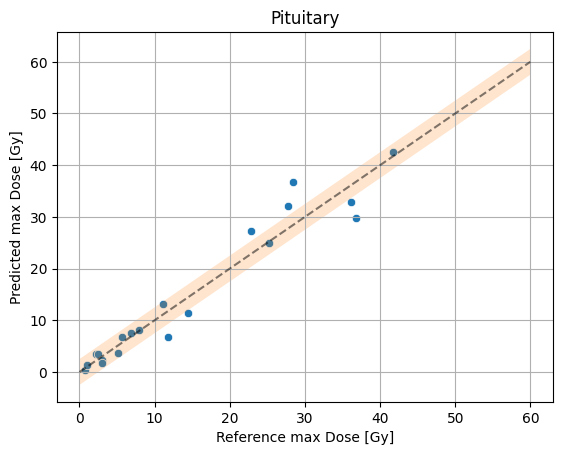

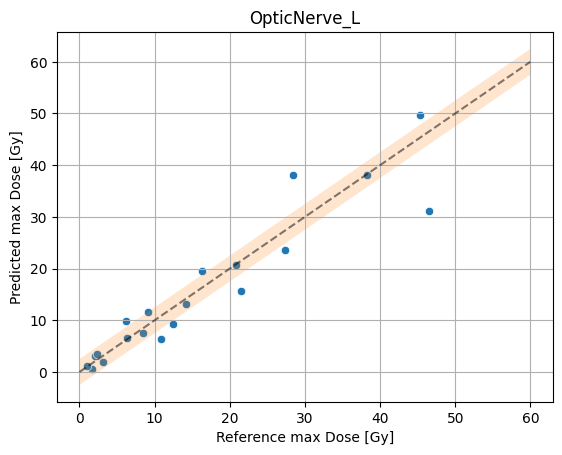

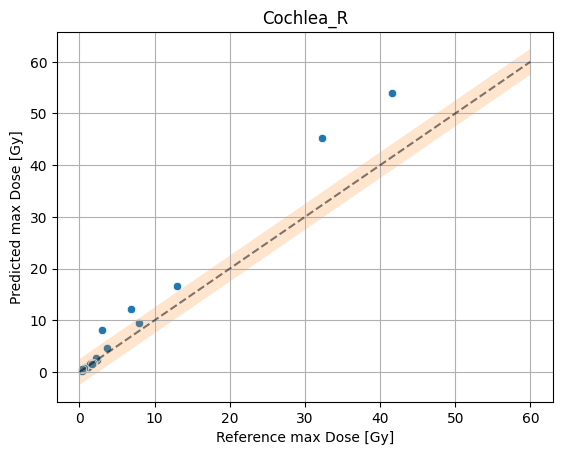

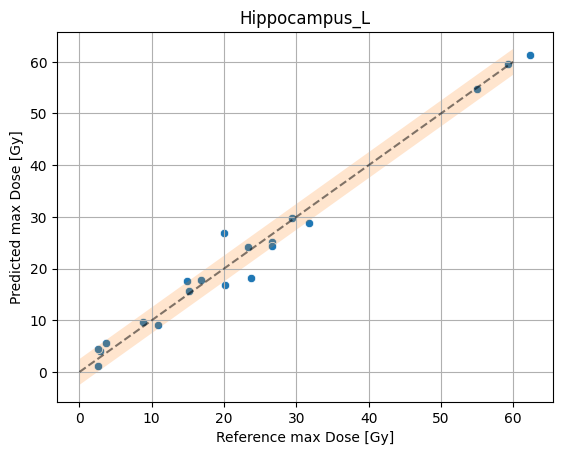

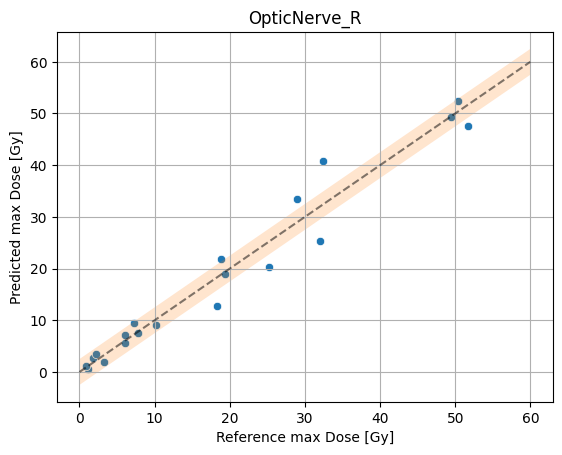

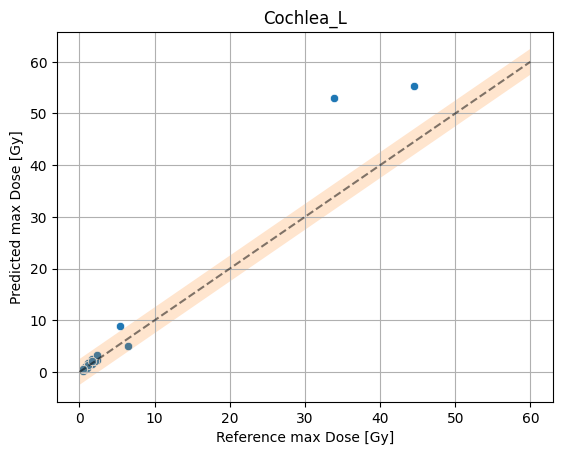

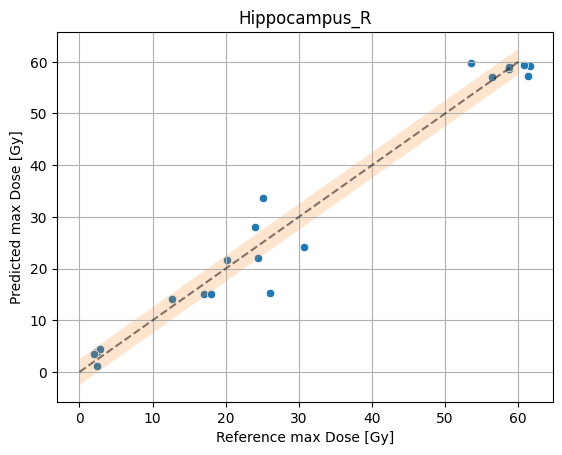

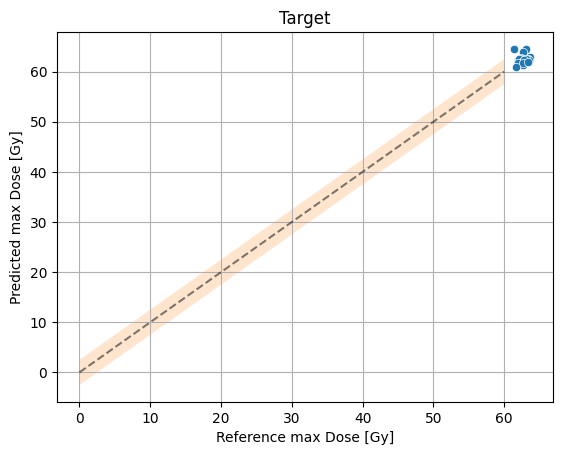

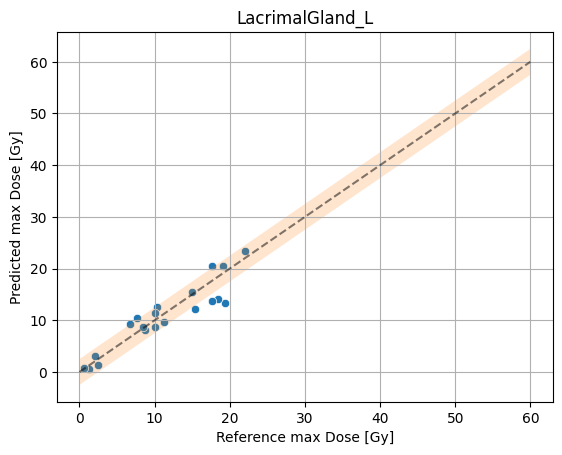

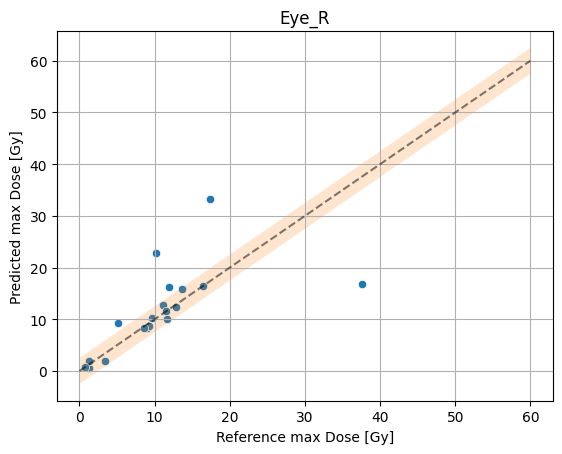

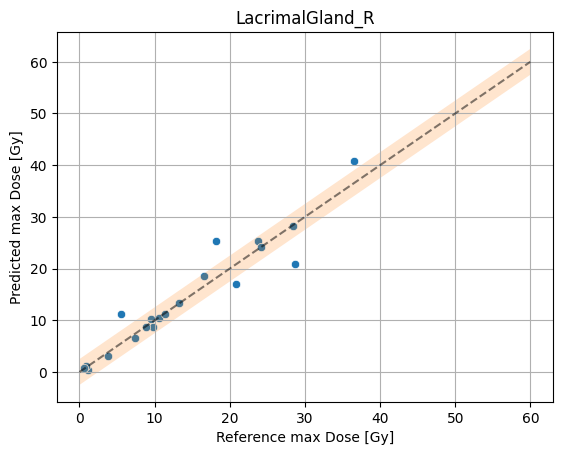

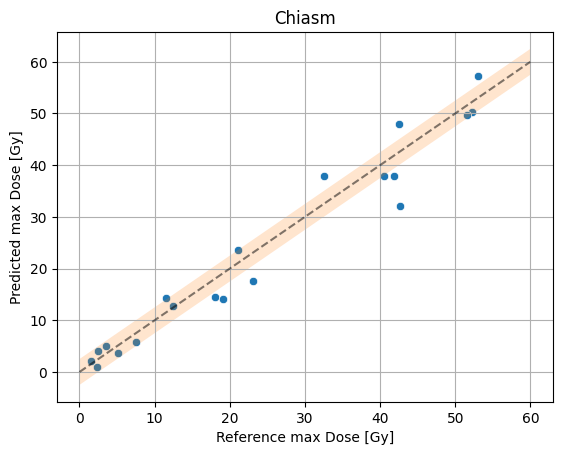

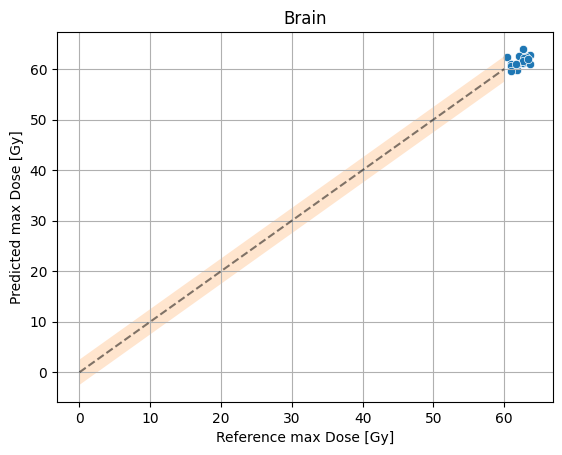

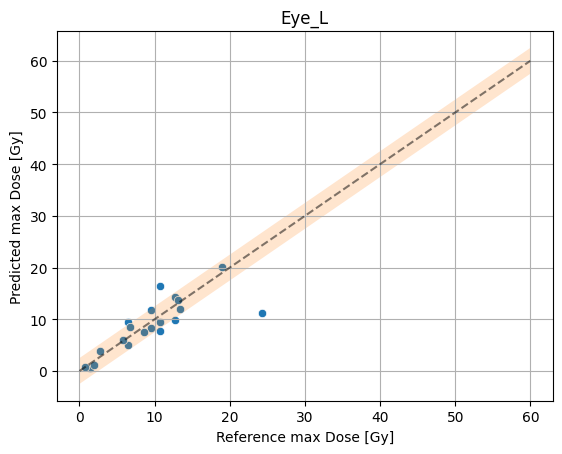

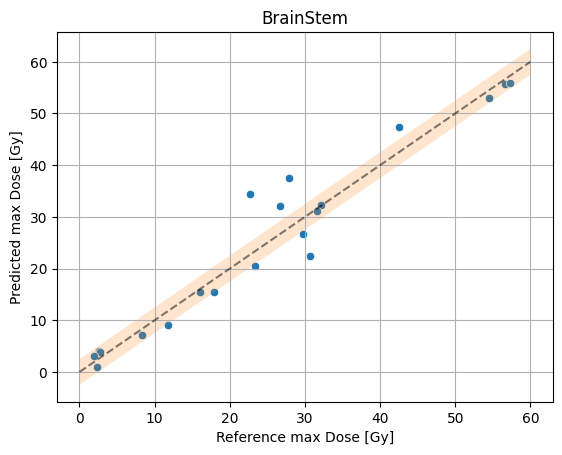

In [14]:
organ_names = mean_gt_dose.index.to_list()
index = np.arange(0, 20, 1)

x = np.arange(0.0, 60, 0.01)
y1 = x + 2.5
y2 = x - 2.5

pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(results_path,"2_test_set_max_variations.pdf"))

for organ in organ_names:
    fig = plt.figure()
    #sns.scatterplot(x=mean_gt_dose.loc[organ, :].to_numpy(), y=mean_pred_dose.loc[organ, :].to_numpy(), hue=index, palette="tab10", size=mean_dose_diff.loc[organ, :].to_numpy(), sizes=(10, 250), size_norm=(0, 10), legend=False)
    sns.scatterplot(x=mean_gt_dose.loc[organ, :].to_numpy(), y=mean_pred_dose.loc[organ, :].to_numpy(), legend=False)
    plt.plot([0, 60], [0, 60], 'k--', alpha=0.5)
    plt.fill_between(x, y1, y2, alpha=0.2)
    plt.grid()
    plt.title(organ)
    plt.xlabel("Reference max Dose [Gy]")
    plt.ylabel("Predicted max Dose [Gy]")
    pdf.savefig(fig)
pdf.close()